# Генерация задания

In [ ]:
from zlib import crc32
import numpy as np

types = ['regression', 'classification']
datasets = {'regression': [{'name': 'Servo Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Servo'},
                           {'name': 'Forest Fires Data Set',
                            'url': 'https://archive.ics.uci.edu/ml/datasets/Forest+Fires'},
                           {'name': 'Boston Housing Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston'},
                           {'name': 'Diabetes Data Set',
                            'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes'}],
            'classification': [{'name': 'Spambase Data Set',
                                'url': 'https://archive.ics.uci.edu/ml/datasets/Spambase'},
                               {'name': 'Wine Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine'},
                               {'name': 'Breast Cancer Data Set',
                                'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'},
                               {'name': 'MNIST',
                                'url': 'http://yann.lecun.com/exdb/mnist/'}]}
methods = {'regression': ['Линейная регрессия',
                          'Перцептрон',
                          'Надарая-Ватсона',
                          'SVR'],
           'classification': ['Логистическая регрессия',
                              'Перцептрон',
                              'k-ближайших соседей',
                              'Метод потенциальных функций',
                              'Метод Парзеновского окна',
                              'SVM']}
task = dict()
task['mail'] = input(prompt='Enter your mail: ')
task['id'] = crc32(task['mail'].encode('utf-8'))
np.random.seed(task['id'])
task['type'] = np.random.choice(types)
task['dataset'] = np.random.choice(datasets[task['type']])
task['method'] = np.random.choice(
    methods[task['type']], size=3, replace=False).tolist()

task

Enter your mail: nikitina.mariia@phystech.edu


{'mail': 'nikitina.mariia@phystech.edu',
 'id': 1191838803,
 'type': 'classification',
 'dataset': {'name': 'Breast Cancer Data Set',
  'url': 'https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer'},
 'method': ['Метод потенциальных функций',
  'Логистическая регрессия',
  'Метод Парзеновского окна']}

# Библиотеки

In [1]:
! pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.6/409.6 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 11.2 MB/s eta 0:00:00


In [40]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 5.8 MB/s eta 0:00:00


In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.metrics import precision_score, recall_score, accuracy_score, RocCurveDisplay
from scipy.spatial.distance import cdist
from mlxtend.plotting import plot_decision_regions
import optuna
import shap
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd

# Данные

In [3]:
# Загрузим датасет и посмотрим на данные
dataset = load_breast_cancer()
data = pd.DataFrame(data=dataset.data, columns=dataset.feature_names)
data['target'] = dataset.target

data.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [ ]:
print(f"Размер выборки составляет l = {len(data)} объектов.")

Размер выборки составляет l = 569 объектов.


На странице sklearn утверждается, что все признаки вещественные. Получаем, что наши данные -- это вещественная матрица $X \in \mathbb{R}^{l \times n}$, где $l = 569$, $n = 30$, а также вектор с метками классов: $0, 1$ длины $l = 569$.

In [ ]:
# В классах может быть дисбаланс. Посмотрим, сколько элементов каждого класса имеется
print("Количество элементов класса 0: {}".format(len(data[data["target"] == 0])))
print("Количество элементов класса 1: {}".format(len(data[data["target"] == 1])))

Количество элементов класса 0: 212
Количество элементов класса 1: 357


Дисбаланс классов имеется, но не критичный.

In [ ]:
# Проверим, все ли данные вещественные
data.dtypes

mean radius                float64
mean texture               float64
mean perimeter             float64
mean area                  float64
mean smoothness            float64
mean compactness           float64
mean concavity             float64
mean concave points        float64
mean symmetry              float64
mean fractal dimension     float64
radius error               float64
texture error              float64
perimeter error            float64
area error                 float64
smoothness error           float64
compactness error          float64
concavity error            float64
concave points error       float64
symmetry error             float64
fractal dimension error    float64
worst radius               float64
worst texture              float64
worst perimeter            float64
worst area                 float64
worst smoothness           float64
worst compactness          float64
worst concavity            float64
worst concave points       float64
worst symmetry      

Посмотрим на корреляцию данных.

In [ ]:
data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-7-96612fe94b20>:1: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  data.corr().style.background_gradient(cmap='coolwarm').set_precision(2)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
mean radius,1.00,0.32,1.00,0.99,0.17,0.51,0.68,0.82,0.15,-0.31,0.68,-0.10,0.67,0.74,-0.22,0.21,0.19,0.38,-0.10,-0.04,0.97,0.30,0.97,0.94,0.12,0.41,0.53,0.74,0.16,0.01,-0.73
mean texture,0.32,1.00,0.33,0.32,-0.02,0.24,0.30,0.29,0.07,-0.08,0.28,0.39,0.28,0.26,0.01,0.19,0.14,0.16,0.01,0.05,0.35,0.91,0.36,0.34,0.08,0.28,0.30,0.30,0.11,0.12,-0.42
mean perimeter,1.00,0.33,1.00,0.99,0.21,0.56,0.72,0.85,0.18,-0.26,0.69,-0.09,0.69,0.74,-0.20,0.25,0.23,0.41,-0.08,-0.01,0.97,0.30,0.97,0.94,0.15,0.46,0.56,0.77,0.19,0.05,-0.74
mean area,0.99,0.32,0.99,1.00,0.18,0.50,0.69,0.82,0.15,-0.28,0.73,-0.07,0.73,0.80,-0.17,0.21,0.21,0.37,-0.07,-0.02,0.96,0.29,0.96,0.96,0.12,0.39,0.51,0.72,0.14,0.00,-0.71
mean smoothness,0.17,-0.02,0.21,0.18,1.00,0.66,0.52,0.55,0.56,0.58,0.30,0.07,0.30,0.25,0.33,0.32,0.25,0.38,0.20,0.28,0.21,0.04,0.24,0.21,0.81,0.47,0.43,0.50,0.39,0.50,-0.36
mean compactness,0.51,0.24,0.56,0.50,0.66,1.00,0.88,0.83,0.60,0.57,0.50,0.05,0.55,0.46,0.14,0.74,0.57,0.64,0.23,0.51,0.54,0.25,0.59,0.51,0.57,0.87,0.82,0.82,0.51,0.69,-0.60
mean concavity,0.68,0.30,0.72,0.69,0.52,0.88,1.00,0.92,0.50,0.34,0.63,0.08,0.66,0.62,0.10,0.67,0.69,0.68,0.18,0.45,0.69,0.30,0.73,0.68,0.45,0.75,0.88,0.86,0.41,0.51,-0.70
mean concave points,0.82,0.29,0.85,0.82,0.55,0.83,0.92,1.00,0.46,0.17,0.70,0.02,0.71,0.69,0.03,0.49,0.44,0.62,0.10,0.26,0.83,0.29,0.86,0.81,0.45,0.67,0.75,0.91,0.38,0.37,-0.78
mean symmetry,0.15,0.07,0.18,0.15,0.56,0.60,0.50,0.46,1.00,0.48,0.30,0.13,0.31,0.22,0.19,0.42,0.34,0.39,0.45,0.33,0.19,0.09,0.22,0.18,0.43,0.47,0.43,0.43,0.70,0.44,-0.33
mean fractal dimension,-0.31,-0.08,-0.26,-0.28,0.58,0.57,0.34,0.17,0.48,1.00,0.00,0.16,0.04,-0.09,0.40,0.56,0.45,0.34,0.35,0.69,-0.25,-0.05,-0.21,-0.23,0.50,0.46,0.35,0.18,0.33,0.77,0.01


Из таблицы корреляции видно, что столбцы "mean fractal dimension", "texture error", "fractal dimension error", "smoothness error" и "symmetry error" можно исключить из рассмотрения, так как их корреляция с целевым значением близка к 0.

Так же, например, "mean perimeter" и "worst perimeter", пусть и имеют большую корреляцию с целевыми значениями, сильно коррелируют между собой и имеют примерно одинаковую корреляцию с целевыми значениями. Это понятно и из логики: среднее и худшее значение сильно зависят друг от друга. Чтобы уменьшить пространство поиска, можно избавиться от одной из этих метрик.

Аналогично удалим "worst radius", "mean area".

In [4]:
data.drop([
    "mean fractal dimension",
    "texture error",
    "fractal dimension error",
    "smoothness error",
    "symmetry error",
    "worst perimeter",
    "worst radius",
    "mean area",
    ], axis=1 , inplace=True)

Визуализировать столько фичей неудобно, можно сделать только для тех, что имеют большую корреляцию с целевой функцией.

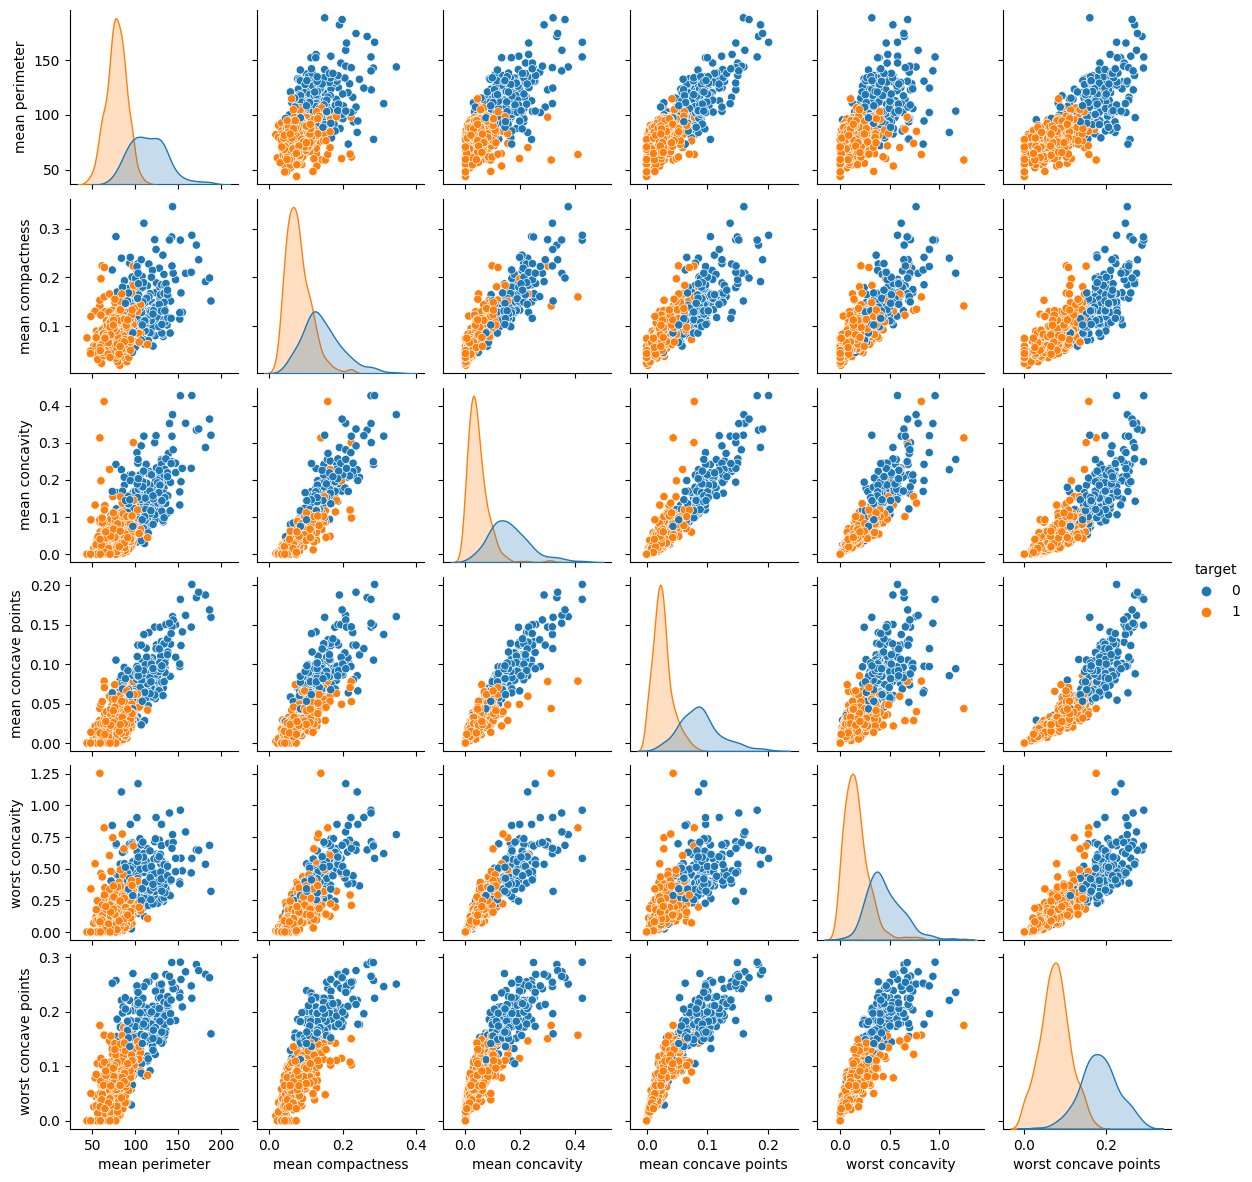

In [ ]:
sns.pairplot(data[[
    "mean perimeter",
    "mean compactness",
    "mean concavity",
    "mean concave points",
    "worst concavity",
    "worst concave points",
    "target"
    ]], hue="target", height=2)
plt.show()

Видим, что данные неплохо отделяются друг от друга.

In [25]:
# Разобьём данные на train и test и отнормируем
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:, data.columns != 'target'],
    data['target'],
    test_size=0.2,
    shuffle=True
)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Функция подсчёта результатов

In [6]:
def print_metrics(y_test, preds):
    scores = {
        "precision": round(precision_score(y_test, preds), 3),
        "recall": round(recall_score(y_test, preds), 3),
        "accuracy": round(accuracy_score(y_test, preds), 3)
    }

    df_scores = pd.DataFrame(scores, index=[""])
    display(df_scores)

# Логистическая регрессия

In [26]:
model = LogisticRegression(random_state=0, max_iter=2000)
_ = model.fit(X_train, y_train)
preds_classes = model.predict(X_test)

print("TRAIN:")
print_metrics(y_train, model.predict(X_train))

print()
print("TEST:")
print_metrics(y_test, model.predict(X_test))

TRAIN:


,precision,recall,accuracy
,0.982,0.993,0.985



TEST:


,precision,recall,accuracy
,0.987,1.0,0.991


In [27]:
X_train_1 = np.array(np.hstack([X_train, np.ones([len(X_train), 1])]), dtype=np.float64)
X_test_1 = np.array(np.hstack([X_test, np.ones([len(X_test), 1])]), dtype=np.float64)
model = LogisticRegression(random_state=0, max_iter=2000)
_ = model.fit(X_train_1, y_train)

print("TRAIN:")
print_metrics(y_train, model.predict(X_train_1))

print()
print("TEST:")
print_metrics(y_test, model.predict(X_test_1))

TRAIN:


,precision,recall,accuracy
,0.982,0.993,0.985



TEST:


,precision,recall,accuracy
,0.987,1.0,0.991


Кажется, добавление размерности не даёт никакого вклада. Возможно потому, что данные уже отнормированы. В дальнейшем не будем увеличивать размерность $X$.

Реализуем поиск гиперпараметров с помощью optuna. Вообще tol и max_iter зависят друг от друга, и можно было бы включать в подбор только один из этих гиперпараметров, но возьмём два. Следующие две ячейки нужно запускать вместе.

In [48]:
def objective(trial):
    # зададим пространство поиска гиперпараметров
    param = {}

    param["penalty"] = trial.suggest_categorical("penalty", ["l2", "elasticnet"])

    if param["penalty"] == "elasticnet":
        param["l1_ratio"] = trial.suggest_float("l1_ratio", 0.0, 1.0)
        param["solver"] = trial.suggest_categorical("elasticnet_solver", ["saga"])
    else:
        param["solver"] = trial.suggest_categorical("l2_solver", ["lbfgs", "newton-cg", "saga"])

    param["C"] = trial.suggest_float("C", 0.1, 10.0, step=0.1)
    param["max_iter"] = trial.suggest_int("max_iter", 100, 3000, step=100)
    param["tol"] = trial.suggest_float("tol", 0.00001, 0.001)

    # получим предсказания
    model = LogisticRegression(**param)
    _ = model.fit(X_train, y_train)
    preds_classes = model.predict(X_test)

    # будем увеличивать среднее арифметическое precision, recall, accuracy
    pr = precision_score(y_test, preds_classes)
    rc = recall_score(y_test, preds_classes)
    acc = accuracy_score(y_test, preds_classes)
    return np.mean([pr, rc, acc])

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="LogReg", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

# сохраним и выведем лучшие гиперпараметры
trial = study.best_trial
best_param = trial.params
df_best_param = pd.DataFrame(best_param, index=[""])
display(df_best_param)

  0%|          | 0/100 [00:00<?, ?it/s]

The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the coef_ did not converge
The max_iter was reached which means the

,penalty,l2_solver,C,max_iter,tol
,l2,saga,8.4,200,0.000489


TRAIN:


The max_iter was reached which means the coef_ did not converge


,precision,recall,accuracy
,0.986,0.993,0.987



TEST:


,precision,recall,accuracy
,0.987,1.0,0.991


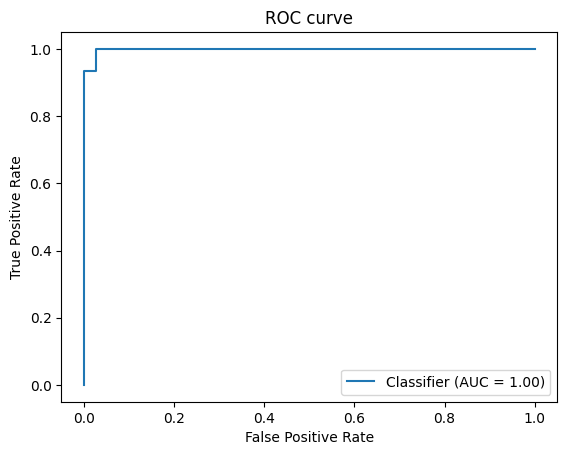

In [49]:
if trial.params["penalty"] == "l2":
    trial.params["solver"] = trial.params.pop("l2_solver")
else:
    trial.params["solver"] = trial.params.pop("elasticnet_solver")

optuna_model = LogisticRegression(**trial.params)
optuna_model.fit(X_train, y_train)

# выведем результат
print("TRAIN:")
print_metrics(y_train, optuna_model.predict(X_train))

print()
print("TEST:")
print_metrics(y_test, optuna_model.predict(X_test))

# посмотрим на ROC-кривую
RocCurveDisplay.from_predictions(y_test, optuna_model.predict_proba(X_test)[:, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

ROC-кривая малоинформативна ввиду того, что тестовая выборка маленькая, а модель работает хорошо.

Сделаем ещё один анализ выборки. Оценим влияние параметров на модель.

  0%|          | 0/114 [00:00<?, ?it/s]

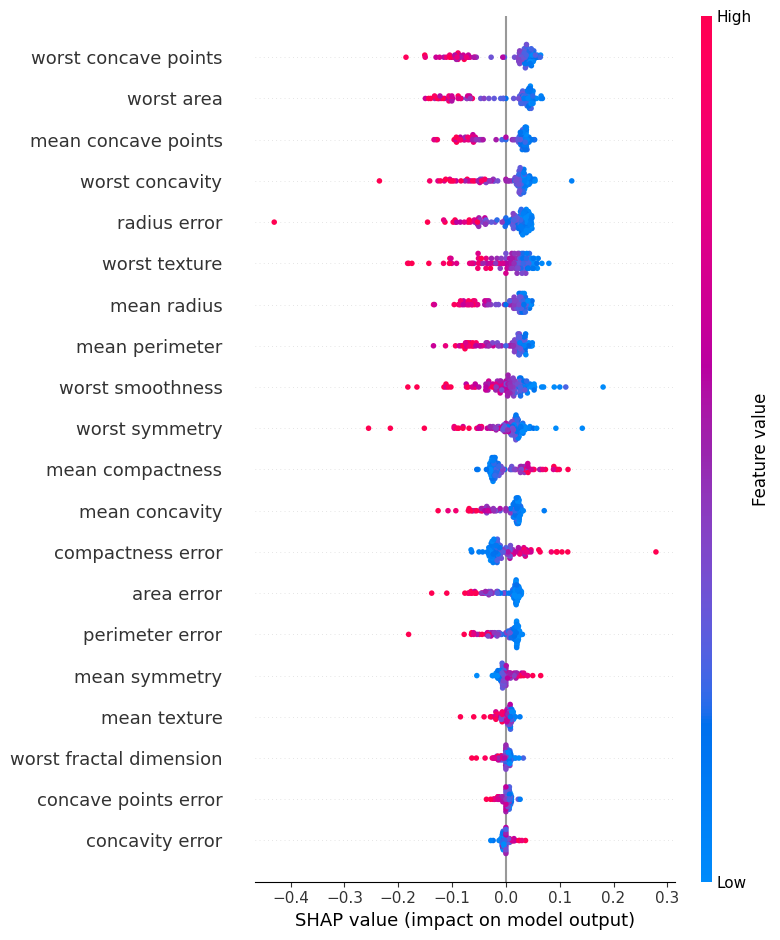

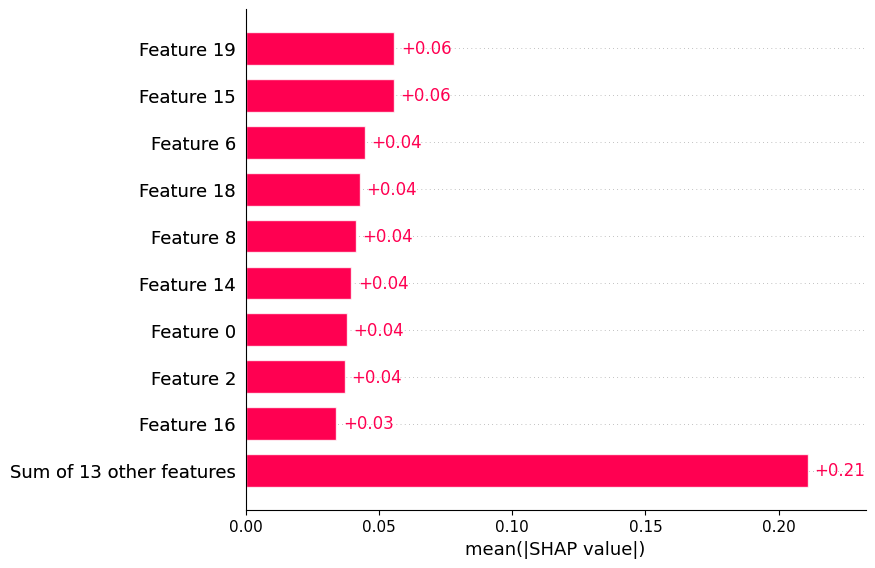

In [52]:
explainer = shap.KernelExplainer(optuna_model.predict, X_test)
shap_values = explainer(X_test)
shap.summary_plot(
    shap_values,
    feature_names=data.loc[:, data.columns != 'target'].columns,
    show=True
)
shap.plots.bar(
    shap_values,
    show=True
)

Посмотрим на зависимость значения метрик от "l1_ratio" при регуляризации "elasticnet".

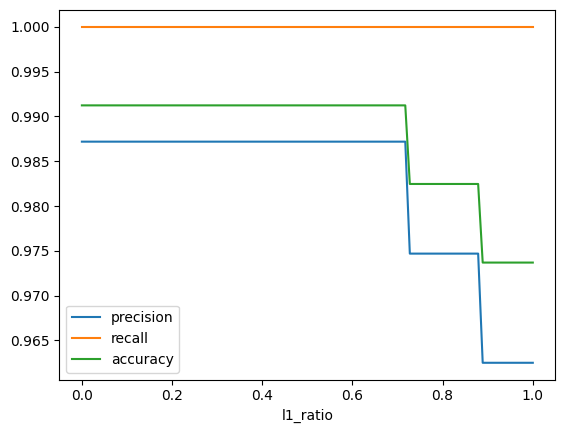

In [31]:
precision = []
recall = []
accuracy = []

l1_ratio_linspace = np.linspace(0, 1, 100)

for l1_ratio in l1_ratio_linspace:
    model = LogisticRegression(
        penalty="elasticnet",
        l1_ratio=l1_ratio,
        solver="saga",
        max_iter=3000
    )
    model.fit(X_train, y_train)

    precision.append(precision_score(y_test, model.predict(X_test)))
    recall.append(recall_score(y_test, model.predict(X_test)))
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(l1_ratio_linspace, precision, label="precision")
plt.plot(l1_ratio_linspace, recall, label="recall")
plt.plot(l1_ratio_linspace, accuracy, label="accuracy")
plt.xlabel("l1_ratio")
plt.legend()

Метрики падают при l1_ratio $> 0.6$. Получаем, что модель работает лучше при l2-регуляризации.

# Метод Парзеновского окна

Будем сравнивать пять вариантов окон: Епанечникова, квартическое, треугольное, гауссовское, прямоугольное.

In [53]:
def K_Epanechnikov(distance, h=0.05):
    ret = np.array(distance) / h
    return 3 / 4 * (1 - ret**2) * (np.abs(ret) <= 1)

def K_Quart(distance, h=0.05):
    ret = np.array(distance) / h
    return 15 / 16 * (1 - ret**2)**2 * (np.abs(ret) <= 1)

def K_Triangular(distance, h=0.05):
    ret = np.array(distance) / h
    return (1 - np.abs(ret)) * (np.abs(ret) <= 1)

def K_Gaussian(distance, h=0.05):
    ret = np.array(distance) / h
    return 1 / np.sqrt(2 * np.pi) * np.exp(- ret**2 / 2)

def K_Rectangular(distance, h=0.05):
    ret = np.array(distance) / h
    return 1 / 2 * (np.abs(ret) <= 1)

Посмотрим, работает ли модель.

In [54]:
model = KNeighborsClassifier(n_neighbors=len(X_train),
                             weights=lambda x: K_Triangular(x, h=5.0))
model.fit(X_train, y_train)

print("TRAIN:")
print_metrics(y_train, model.predict(X_train))

print()
print("TEST:")
print_metrics(y_test, model.predict(X_test))

TRAIN:


,precision,recall,accuracy
,0.906,0.996,0.934



TEST:


,precision,recall,accuracy
,0.906,1.0,0.93


In [57]:
def objective(trial):
    # зададим пространство поиска гиперпараметров
    windows_list = ["K_Epanechnikov", "K_Quart", "K_Triangular", "K_Gaussian", "K_Rectangular"]
    window = trial.suggest_categorical("window", windows_list)

    param = {}
    h=trial.suggest_float("h", 0.05, 10.0, step=0.05)
    param["weights"] = lambda x: eval(window)(x, h=h)
    param["metric"] = trial.suggest_categorical("metric", ["minkowski", "manhattan"])
    param["algorithm"] = trial.suggest_categorical("algorithm", ["ball_tree", "kd_tree", "brute"])
    if param["algorithm"] != "brute":
        param["leaf_size"] = trial.suggest_int("leaf_size", 5, 50)

    # получим предсказания
    model = KNeighborsClassifier(n_neighbors=len(X_train), **param)
    model.fit(X_train, y_train)
    preds_classes = model.predict(X_test)

    # будем увеличивать среднее арифметическое precision, recall, accuracy
    pr = precision_score(y_test, preds_classes)
    rc = recall_score(y_test, preds_classes)
    acc = accuracy_score(y_test, preds_classes)
    return np.mean([pr, rc, acc])

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="Parzen_window", direction="maximize")
study.optimize(objective, n_trials=100, show_progress_bar=True)

trial = study.best_trial
best_param = trial.params
df_best_param = pd.DataFrame(best_param, index=[""])
display(df_best_param)

  0%|          | 0/100 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,window,h,metric,algorithm,leaf_size
,K_Quart,9.65,manhattan,ball_tree,29


In [58]:
param = {}
for key, value in best_param.items():
    if key not in ["window", "h"]:
        param[key] = value

optuna_model = KNeighborsClassifier(
    n_neighbors=len(X_train),
    weights=lambda x: eval(best_param["window"])(x, h=best_param["h"]),
    **param)
optuna_model.fit(X_train, y_train)
print("TRAIN:")
print_metrics(y_train, optuna_model.predict(X_train))

print()
print("TEST:")
print_metrics(y_test, optuna_model.predict(X_test))

value=0
width=20

filler_feature_values = {}
filler_feature_ranges = {}

for i in range(2, 22):
    filler_feature_values[i] = value
    filler_feature_ranges[i] = width

TRAIN:


,precision,recall,accuracy
,0.976,1.0,0.985



TEST:


,precision,recall,accuracy
,0.987,0.974,0.974


Посмотрим на результаты в зависимости от выбора окна.

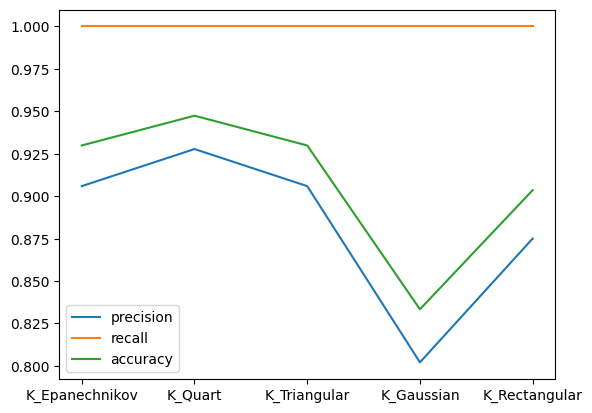

In [36]:
windows_list = ["K_Epanechnikov", "K_Quart", "K_Triangular", "K_Gaussian", "K_Rectangular"]
precision = []
recall = []
accuracy = []

for window in windows_list:
    model = KNeighborsClassifier(
        n_neighbors=len(X_train),
        weights=lambda x: eval(window)(x, h=5.0),
        metric="minkowski",
        algorithm="kd_tree",
        leaf_size=30
    )
    model.fit(X_train, y_train)

    # будем увеличивать среднее арифметическое precision, recall, accuracy
    precision.append(precision_score(y_test, model.predict(X_test)))
    recall.append(recall_score(y_test, model.predict(X_test)))
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot(windows_list, precision, label="precision")
plt.plot(windows_list, recall, label="recall")
plt.plot(windows_list, accuracy, label="accuracy")
plt.legend()

Делаем вывод, что каждое окно требует специфичных настроек других гиперпараметров. "K_Gaussian", например, предпочитает метрику "manhattan", в то время, как другие окна на ней зачастую ломаются, что видно по warning во время подбора гиперпараметров.

# Метод потенциальных функций

Реализация метода взята из семинара.

In [37]:
class PFM(object):
    def __init__(self, kernel=None):
        self.X, self.Y, self.gams = None, None, None
        self.kernel = lambda x: np.ones_like(x)
        if kernel is not None:
            self.kernel = kernel

    def scores(self, X):
        features = self.gams*self.kernel(cdist(X, self.X))
        scores = np.vstack(
            [np.sum(features.T[np.where(self.Y==0)[0]].T, axis=-1),
             np.sum(features.T[np.where(self.Y==1)[0]].T, axis=-1)]).T
        return scores

    def predict(self, X):
        return np.argmax(self.scores(X), axis=-1)

    def fit(self, X, Y, epoch=10):
        self.X, self.Y, self.gams = np.array(X), np.array(Y), np.zeros_like(Y)
        for _ in range(epoch):
            for i, (x, y) in enumerate(zip(self.X, self.Y)):
                if self.predict(np.array([x]))[0] != y:
                    self.gams[i] += 1

In [38]:
model = PFM(kernel=lambda x: K_Epanechnikov(x, h=5.0))
model.fit(X_train, y_train)

print("TRAIN:")
print_metrics(y_train, model.predict(X_train))

print()
print("TEST:")
print_metrics(y_test, model.predict(X_test))

TRAIN:


,precision,recall,accuracy
,0.957,0.943,0.938



TEST:


,precision,recall,accuracy
,0.961,0.948,0.939


In [65]:
def objective(trial):
    # зададим пространство поиска гиперпараметров
    windows_list = ["K_Epanechnikov", "K_Quart", "K_Triangular", "K_Gaussian", "K_Rectangular"]
    window = trial.suggest_categorical("window", windows_list)

    param = {}
    h=trial.suggest_float("h", 0.05, 10.0, step=0.05)
    kernel = lambda x: eval(window)(x, h=h)
    epoch = trial.suggest_int("epoch", 5, 100)

    # получим предсказания
    model = PFM(kernel=kernel)
    model.fit(X_train, y_train, epoch=epoch)
    preds_classes = model.predict(X_test)

    # будем увеличивать среднее арифметическое precision, recall, accuracy
    pr = precision_score(y_test, preds_classes)
    rc = recall_score(y_test, preds_classes)
    acc = accuracy_score(y_test, preds_classes)
    return np.mean([pr, rc, acc])

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(study_name="PFM", direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

trial = study.best_trial
best_param = trial.params
df_best_param = pd.DataFrame(best_param, index=[""])
display(df_best_param)

  0%|          | 0/50 [00:00<?, ?it/s]

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


,window,h,epoch
,K_Triangular,6.7,26


In [66]:
model = PFM(lambda x: eval(best_param["window"])(x, h=best_param["h"]))
model.fit(X_train, y_train, epoch=best_param["epoch"])

print("TRAIN:")
print_metrics(y_train, model.predict(X_train))

print()
print("TEST:")
print_metrics(y_test, model.predict(X_test))

TRAIN:


,precision,recall,accuracy
,1.0,1.0,1.0



TEST:


,precision,recall,accuracy
,0.987,1.0,0.991


Посмотрим на зависимость результата от числа эпох.

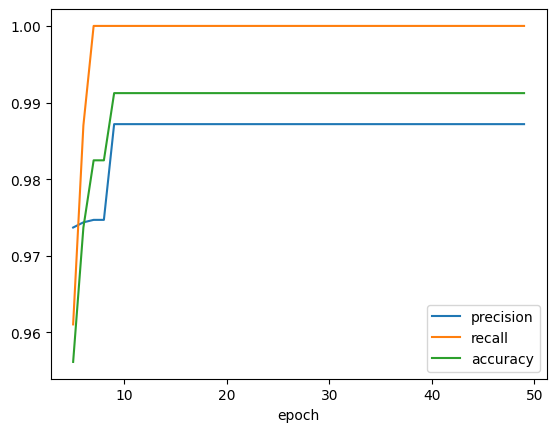

In [67]:
precision = []
recall = []
accuracy = []

for epoch in range(5, 50):
    model = PFM(kernel=lambda x: K_Triangular(x, h=6.7))
    model.fit(X_train, y_train, epoch=epoch)

    precision.append(precision_score(y_test, model.predict(X_test)))
    recall.append(recall_score(y_test, model.predict(X_test)))
    accuracy.append(accuracy_score(y_test, model.predict(X_test)))

plt.plot([i for i in range(5, 50)], precision, label="precision")
plt.plot([i for i in range(5, 50)], recall, label="recall")
plt.plot([i for i in range(5, 50)], accuracy, label="accuracy")
plt.xlabel("epoch")
plt.legend()

Модель имеет стабильно хорошие метрики.

# Выводы

Как видно для результатов поиска гиперпараметров, метрики нестабильны ввиду того, что датасет маленький. Перезапуск поиска вполне может дать абсолютно другой набор гиперпараметров.

Для каждой модели удалось получить значение метрик не меньше 0.97 на тесте, что очень неплохо. Для такого небольшого датасета хороший результат.

Также отметим, что нам удалось получить recall = 1.0. Датасет связан с диагностированием заболевания, а, значит, мы свели к минимуму ошибку первого рода, что критично для данной задачи.

## Логистическая регрессия
Самая удобная для использования -- логистическая регрессия, так как для неё существует пакетный метод с большим выбором гиперпараметров. К тому же, эта модель обучается быстрее всего. Из анализа "elasticnet" регуляризации выяснили, что l2-регуляризация предпочтительнее l1. Единственное, что вызывает неоднозначные чувства -- стабильно хороший результат при различных значениях гиперпараметров. Кажется, что тяжело его улучшить по сравнению с запуском с базовыми настройками.

## Метод Парзеновского окна
"Полупакетный" метод. Плох тем, что каждое окно требует свой набор гиперпараметров, и провести сравнительный анализ работы каждого окна при прочих равных гиперпараметрах сложно. Для этого метода подбор уже помог улучшить результаты, но они не больше, чем у логистической регрессии.

## Метод потенциальных функций
Однако, лучший результат показал метод потенциальных функций, который обучался дольше всего. Датасет слишком маленький, чтобы уверенно говорить, что модель лучше, только потому, что она показала лучший результат. К тому же, при первом тестовом запуске "из коробки" метод потенциальных функций показал худший результат. Имеет ту же проблему с окнами, что и метод Парзеновского окна. Нет реализации метода в библиотеках, поэтому он негибкий в плане количества гиперпараметров и возможностей их настройки.